### Co-occurrence Matrix

according to [Wikipedia](https://en.wikipedia.org/wiki/GloVe),

Let the vocabulary be $V$, the set of all possible words (aka "tokens").

Let $X_{ij}$ be the number of times that the word $j$ appears in the context of the word $i$ over the entire corpus.

Let $X_{i}=\sum _{j\in V}X_{ij}$ be the number of words in the context of all instances of word $i$. By counting, we have $$X_{i}=2\times ({\text{context size}})\times \#({\text{occurrences of word }}i)$$
(except for words occurring right at the start and end of the corpus)

Let 
$$ P_{ik} = P(k|i) = {\frac {X_{ik}}{X_{i}}} $$
be the co-occurrence probability. That is, if one samples a random occurrence of the word $i$ in the entire document, and a random word within its context, that word is $k$ with probability $P_{ik}$. Note that $P_{ik}\neq P_{ki}$ in general.

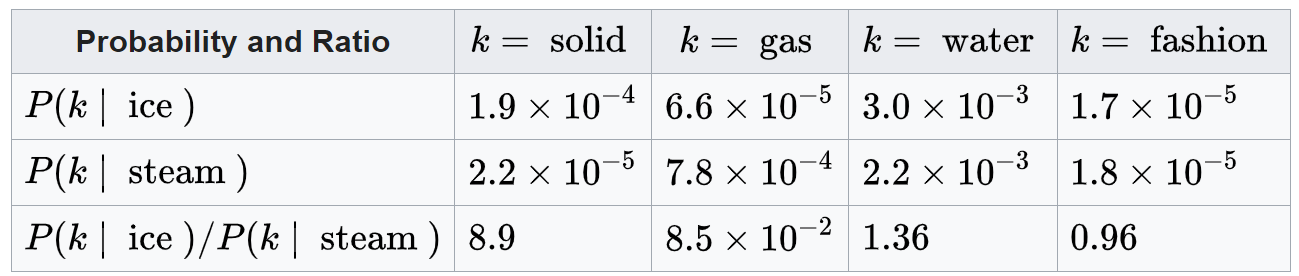


### Least Squares Objective
The idea is to learn two vectors $ w_{i},{\tilde {w}}_{i}$ for each word $i$, such that we have a multinomial logistic regression:
$$w_{i}^{T}{\tilde {c}}_{j}+b_{i}+{\tilde {b}}_{j}\approx \ln P_{ij}$$ 
and the terms $b_{i},{\tilde {b}}_{j}$ are unimportant parameters.

Naively, logistic regression can be run by minimizing the squared loss:
$$ L=\sum _{i,j\in V}(w_{i}^{T}{\tilde {w}}_{j}+b_{i}+{\tilde {b}}_{j}-\ln P_{ik})^{2}$$


However, this would be noisy for rare co-occurrences. To fix the issue, the squared loss is weighted so that the loss is slowly ramped-up as the absolute number of co-occurrences $X_{ij}$ increases:

$$ L=\sum _{i,j\in V}f(X_{ij})(w_{i}^{T}{\tilde {c}}_{j}+b_{i}+{\tilde {b}}_{j}-\ln P_{ik})^{2}$$

where 
$$f(x)=\left\{{\begin{array}{cc}\left(x/x_{\max }\right)^{\alpha }&{\text{ if }}x<x_{\max }\\1&{\text{ otherwise }}\end{array}}\right.$$

and $x_{\max },\alpha$ are hyperparameters. In the original paper, the authors found that $x_{\max }=100$, $\alpha =3/4$ seems to work well in practice.

### Gradient Descent

Let 
$$ e_{ij} = w_{i}^{T}{\tilde {c}}_{j}+b_{i}+{\tilde {b}}_{j}-\ln P_{ik}$$Then we have: 

$$ \frac{\partial L}{\partial w_{i}} = 2f \left( X_{ij} \right) e_{ij} c_{j}$$

$$ \frac{\partial L}{\partial c_{j}} = 2f \left( X_{ij} \right) e_{ij} w_{i}$$

$$ \frac{\partial L}{\partial b_{i}} = 2f \left( X_{ij} \right)  e_{ij} $$

$$ \frac{\partial L}{\partial {\tilde {b}}_{j}} = 2f \left( X_{ij} \right)  e_{ij} $$


In [17]:
import numpy as np
import gensim.downloader as api
import itertools

### Prepare the data

[Training data](https://mattmahoney.net/dc/textdata.html) comes from gensim.

In [14]:
dataset = api.load("text8")
corpus = list(itertools.chain.from_iterable(dataset))

print("length:", len(corpus), "\n", corpus[:10])

length: 17005207 
 ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [18]:
class GloVe:
    
    '''
    W: word vector
    C: context vector
    '''
    
    def __init__(self, vector_dim=50, window_size=5, alpha=0.75, x_max=100.0):
        self.vector_dim = vector_dim
        self.window_size = window_size
        self.alpha = alpha
        self.x_max = x_max
        self.vocab = None
        self.word_to_index = None
        self.cooccurence_matrix = None
        self.W = None
        self.W_bias = None
        self.C = None 
        self.C_bias = None
        
        self.loss_history = None
        
        
    def fit(self, tokens):
        self._create_cooccurence_matrix(tokens)
        self._initialize_parameters()
        self._optmize_glove()
        
    
    
    
    def _create_coocurrence_matrix(self, tokens):

        self.vocab = list(set(tokens))
        vocab_size = len(self.vocab)
        self.word_to_index = {word: i for i in word in enumerate(self.vocab)}


        self.cooccurence_matrix = np.zeros((vocab_size, vocab_size))

        for i, word in enumerate(tokens):
            word_idx = word_to_index[word]
            for j in range(max(0, i-self.window_size), min(len(tokens), i+self.window_size+1)):
                if i != j: # exclude the word i itself
                    contex_word = tokens[j]
                    context_idx = word_to_idx[context_word]
                    self.cooccurence_matrix[word_idx, context_idx] += 1
     
    
    
    def _weighting_function(self, count):
        '''
        count: cooccurence count of word_idx and context_idx
        '''
        if count < self.x_max:
            return (count / self.x_max) ** self.alpha
        
        
        
    def _cost_function(self, word_idx, context_idx):
        '''
        cost function for each word
        '''
        weight = self._weighting_function(_create_coocurrence_matrix[word_idx, context_idx])
        cooccur_count = self.cooccurence_matrix[word_idx, context_idx]
        cost = weight * (self.W[word_idx] @ self.C[context_idx] + self.W_bias[word_idx] + self.C_bias[context_idx] - np.log(cooccur_count)) ** 2
        return cost
    
    
    def _optimize_glove(self):
        self.loss_history = []
        vocab_size = len(self.vocab)
        for epoch in range(self.epochs):
            loss = 0
            for word_idx in range(vocab_size):
                for context_idx in range(vocab_size):
                    if self.cooccurence_matrix[word_idx, context_idx] > 0:
                        cost = self._cost_function(word_idx, context_idx)
                        total_cost += cost
                        self._update_parameters(word_idx, context_idx)
            self.loss_history.append(loss)

        print(f"Epoch: {epoch + 1}, loss: {loss}")
        
        
        
    def _update_parameters(self, word_idx, context_idx):
        weight = self._weighting_function(self.cooccurence_matrix[word_idx, context_idx])
        inner_product = np.dot(self.W[word_idx], self.C[context_idx])
        bias_term = self.W_bias[word_idx] + self.C_bias[context_idx]
        cooccur_count = self.cooccurence_matrix[word_idx, context_idx]
        error = inner_product + bias_term - np.log(cooccur_count)

        grad_w = weight * error * self.C[context_idx]
        grad_c = weight * error * self.W[word_idx]
        grad_w_bias = weight * error
        grad_c_bias = weight * error

        self.W[word_idx] -= self.learning_rate * grad_w
        self.C[context_idx] -= self.learning_rate * grad_c
        self.W_bias[word_idx] -= self.learning_rate * grad_w_bias
        self.C_bias[context_idx] -= self.learning_rate * grad_c_bias 
            
        

IndentationError: expected an indented block after function definition on line 43 (2391778496.py, line 44)

In [ ]:
class GloVe:
    
    '''
    W: word vector
    C: context vector
    '''
    
    
    def __init__(self, vector_dim=50, window_size=5, alpha=0.75, x_max=100.0, learning_rate=0.05, epochs=100):
    self.vector_dim = vector_dim
    self.window_size = window_size
    self.alpha = alpha
    self.x_max = x_max
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.vocab = None
    self.word_to_index = None
    self.cooccurence_matrix = None
    self.W = None
    self.W_bias = None
    self.C = None 
    self.C_bias = None

def fit(self, tokens):
    self._create_coocurrence_matrix(tokens)
    self._initialize_parameters()
    self._optimize_glove()

def _create_coocurrence_matrix(self, tokens):
    self.vocab = list(set(tokens))
    vocab_size = len(self.vocab)
    self.word_to_index = {word: i for i, word in enumerate(self.vocab)}

    self.cooccurence_matrix = np.zeros((vocab_size, vocab_size))

    for i, word in enumerate(tokens):
        word_idx = self.word_to_index[word]
        for j in range(max(0, i - self.window_size), min(len(tokens), i + self.window_size + 1)):
            if i != j:  # exclude the word i itself
                context_word = tokens[j]
                context_idx = self.word_to_index[context_word]
                self.cooccurence_matrix[word_idx, context_idx] += 1

def _initialize_parameters(self):
    vocab_size = len(self.vocab)
    self.W = np.random.uniform(-0.5, 0.5, (vocab_size, self.vector_dim))
    self.C = np.random.uniform(-0.5, 0.5, (vocab_size, self.vector_dim))
    self.W_bias = np.zeros(vocab_size)
    self.C_bias = np.zeros(vocab_size)

def _weighting_function(self, count):
    if count < self.x_max:
        return (count / self.x_max) ** self.alpha
    else:
        return 1.0

def _cost_function(self, word_idx, context_idx):
    weight = self._weighting_function(self.cooccurence_matrix[word_idx, context_idx])
    inner_product = np.dot(self.W[word_idx], self.C[context_idx])
    bias_term = self.W_bias[word_idx] + self.C_bias[context_idx]
    cooccur_count = self.cooccurence_matrix[word_idx, context_idx]

    return weight * (inner_product + bias_term - np.log(cooccur_count)) ** 2

def _optimize_glove(self):
    vocab_size = len(self.vocab)
    for epoch in range(self.epochs):
        total_cost = 0
        for word_idx in range(vocab_size):
            for context_idx in range(vocab_size):
                if self.cooccurence_matrix[word_idx, context_idx] > 0:
                    cost = self._cost_function(word_idx, context_idx)
                    total_cost += cost
                    self._update_parameters(word_idx, context_idx)

        print(f"Epoch: {epoch + 1}, Cost: {total_cost}")

def _update_parameters(self, word_idx, context_idx):
    weight = self._weighting_function(self.cooccurence_matrix[word_idx, context_idx])
    inner_product = np.dot(self.W[word_idx], self.C[context_idx])
    bias_term = self.W_bias[word_idx] + self.C_bias[context_idx]
    cooccur_count = self.cooccurence_matrix[word_idx, context_idx]
    error = inner_product + bias_term - np.log(cooccur_count)

    grad_w = weight * error * self.C[context_idx]
    grad_c = weight * error * self.W[word_idx]
    grad_w_bias = weight * error
    grad_c_bias = weight * error

    self.W[word_idx] -= self.learning_rate * grad_w
    self.C[context_idx] -= self.learning_rate * grad_c
    self.W_bias[word_idx] -= self.learning_rate * grad_w_bias
    self.C_bias[context_idx] -= self.learning_rate * grad_c_bias 